In [1]:
## Refer this link
## https://towardsdatascience.com/natural-language-processing-in-apache-spark-using-nltk-part-2-2-5550b85f3340

In [1]:
import os
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

from pyspark.sql import SparkSession
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession as F
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0-preview2,' \
                                    'org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0-preview2 pyspark-shell '


In [2]:
conf=pyspark.SparkConf().setAppName('Tweets_kafka').setMaster('local')
sc=pyspark.SparkContext(conf=conf)
spark=SparkSession(sc) 

In [7]:
df = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "Tweets_file") \
    .option("startingOffsets", "earliest") \
    .load()

In [8]:
data=df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [9]:
data.show(10)

+----+--------------------+
| key|               value|
+----+--------------------+
|null|"RT @angelicaxval...|
|null|"RT @cumaicten: K...|
|null|"RT @DonaldJTrump...|
|null|"@hd_kumaraswamy ...|
|null|"@samkipyego @ker...|
|null|"RT @aysen_tok: #...|
|null|"RT @StijnJansen9...|
|null|"@rilknem @felipe...|
|null|"RT @DonaldJTrump...|
|null|"@qutuba Wo abhi ...|
+----+--------------------+
only showing top 10 rows



In [10]:
reviews_rdd = data.select("value").rdd.flatMap(lambda x: x)
reviews_rdd.collect()

['"RT @angelicaxval: they\\u2019re being gassed, exposed to corona virus, raped by staff, sitting in their own pee &amp; shit, children going \\u201cmissing\\u201d,\\u2026"',
 '"RT @cumaicten: K\\u0131z\\u0131m Corona vir\\u00fcs tedavisi bir ay s\\u00fcrd\\u00fc, son 10 g\\u00fcn\\u00fcn\\u00fcn nas\\u0131l ge\\u00e7ti\\u011fini ya\\u015fayanlar bilir, \\u015fimdi ise hi\\u00e7 bir tedbir al\\u0131nmada\\u2026"',
 '"RT @DonaldJTrumpJr: But in these liberal states you still can\\u2019t go to Work, School, or Church. Corona is cancelled!!! Enough already."',
 '"@hd_kumaraswamy *FUTURE*\\nTo see this future you do not need divine vision\\n\\nSimple Logic is enough\\n\\nBangalore would\\u2026 https://t.co/78XTK1IM93"',
 '"@samkipyego @kerubo_hillary We can have a different discussion from corona"',
 '"RT @aysen_tok: #Yara Nehirlerin denizlere, denizlerin nehirlere kar\\u0131\\u015ft\\u0131\\u011f\\u0131 noktada...\\n#Tortu\\n#Y\\u0131lan\\n#Aslesha\\n#\\u015eifa \\u00c7in\\u2019in Wuhan \

In [10]:
###Remove the header and convert all the data into lowercase for easy processing.

In [11]:
header = reviews_rdd.first()
data_rmv_col = reviews_rdd.filter(lambda row: row != header)

lowerCase_sentRDD = data_rmv_col.map(lambda x : x.lower())

In [12]:
lowerCase_sentRDD.collect()

['"rt @cumaicten: k\\u0131z\\u0131m corona vir\\u00fcs tedavisi bir ay s\\u00fcrd\\u00fc, son 10 g\\u00fcn\\u00fcn\\u00fcn nas\\u0131l ge\\u00e7ti\\u011fini ya\\u015fayanlar bilir, \\u015fimdi ise hi\\u00e7 bir tedbir al\\u0131nmada\\u2026"',
 '"rt @donaldjtrumpjr: but in these liberal states you still can\\u2019t go to work, school, or church. corona is cancelled!!! enough already."',
 '"@hd_kumaraswamy *future*\\nto see this future you do not need divine vision\\n\\nsimple logic is enough\\n\\nbangalore would\\u2026 https://t.co/78xtk1im93"',
 '"@samkipyego @kerubo_hillary we can have a different discussion from corona"',
 '"rt @aysen_tok: #yara nehirlerin denizlere, denizlerin nehirlere kar\\u0131\\u015ft\\u0131\\u011f\\u0131 noktada...\\n#tortu\\n#y\\u0131lan\\n#aslesha\\n#\\u015eifa \\u00c7in\\u2019in wuhan \\u015fehrinin g\\u00fcn\\u2026"',
 '"rt @stijnjansen90: dan ben ik ontzettend benieuwd naar de dekking voor het redden van klm en scheepsbouwer ihc. en de dekking van alle cor

In [13]:
###Text data can be split into sentences and this process is called sentence tokenization.

In [22]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pandas as pd
import re
import string

In [23]:
def sent_TokenizeFunct(x):
    return nltk.sent_tokenize(x)
sentenceTokenizeRDD = lowerCase_sentRDD.map(sent_TokenizeFunct)


In [24]:
sentenceTokenizeRDD.collect()

[['"rt @cumaicten: k\\u0131z\\u0131m corona vir\\u00fcs tedavisi bir ay s\\u00fcrd\\u00fc, son 10 g\\u00fcn\\u00fcn\\u00fcn nas\\u0131l ge\\u00e7ti\\u011fini ya\\u015fayanlar bilir, \\u015fimdi ise hi\\u00e7 bir tedbir al\\u0131nmada\\u2026"'],
 ['"rt @donaldjtrumpjr: but in these liberal states you still can\\u2019t go to work, school, or church.',
  'corona is cancelled!!!',
  'enough already."'],
 ['"@hd_kumaraswamy *future*\\nto see this future you do not need divine vision\\n\\nsimple logic is enough\\n\\nbangalore would\\u2026 https://t.co/78xtk1im93"'],
 ['"@samkipyego @kerubo_hillary we can have a different discussion from corona"'],
 ['"rt @aysen_tok: #yara nehirlerin denizlere, denizlerin nehirlere kar\\u0131\\u015ft\\u0131\\u011f\\u0131 noktada...\\n#tortu\\n#y\\u0131lan\\n#aslesha\\n#\\u015eifa \\u00c7in\\u2019in wuhan \\u015fehrinin g\\u00fcn\\u2026"'],
 ['"rt @stijnjansen90: dan ben ik ontzettend benieuwd naar de dekking voor het redden van klm en scheepsbouwer ihc.',
  '

In [25]:
###Step 6: Now split each sentence into words, also called word tokenization.

In [26]:
def word_TokenizeFunct(x):
    splitted = [word for line in x for word in line.split()]
    return splitted
wordTokenizeRDD = sentenceTokenizeRDD.map(word_TokenizeFunct)

In [27]:
wordTokenizeRDD.collect()

[['"rt',
  '@cumaicten:',
  'k\\u0131z\\u0131m',
  'corona',
  'vir\\u00fcs',
  'tedavisi',
  'bir',
  'ay',
  's\\u00fcrd\\u00fc,',
  'son',
  '10',
  'g\\u00fcn\\u00fcn\\u00fcn',
  'nas\\u0131l',
  'ge\\u00e7ti\\u011fini',
  'ya\\u015fayanlar',
  'bilir,',
  '\\u015fimdi',
  'ise',
  'hi\\u00e7',
  'bir',
  'tedbir',
  'al\\u0131nmada\\u2026"'],
 ['"rt',
  '@donaldjtrumpjr:',
  'but',
  'in',
  'these',
  'liberal',
  'states',
  'you',
  'still',
  'can\\u2019t',
  'go',
  'to',
  'work,',
  'school,',
  'or',
  'church.',
  'corona',
  'is',
  'cancelled!!!',
  'enough',
  'already."'],
 ['"@hd_kumaraswamy',
  '*future*\\nto',
  'see',
  'this',
  'future',
  'you',
  'do',
  'not',
  'need',
  'divine',
  'vision\\n\\nsimple',
  'logic',
  'is',
  'enough\\n\\nbangalore',
  'would\\u2026',
  'https://t.co/78xtk1im93"'],
 ['"@samkipyego',
  '@kerubo_hillary',
  'we',
  'can',
  'have',
  'a',
  'different',
  'discussion',
  'from',
  'corona"'],
 ['"rt',
  '@aysen_tok:',
  '#yara'

In [28]:
###Step 7: To move ahead first we will clean our data, here we’re gonna remove stopwords, punctuations, and empty spaces.

In [29]:
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence
stopwordRDD = wordTokenizeRDD.map(removeStopWordsFunct)

def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered
rmvPunctRDD = stopwordRDD.map(removePunctuationsFunct)

In [30]:
rmvPunctRDD.collect()

[['rt',
  'cumaicten',
  'ku0131zu0131m',
  'corona',
  'viru00fcs',
  'tedavisi',
  'bir',
  'ay',
  'su00fcrdu00fc',
  'son',
  '10',
  'gu00fcnu00fcnu00fcn',
  'nasu0131l',
  'geu00e7tiu011fini',
  'yau015fayanlar',
  'bilir',
  'u015fimdi',
  'ise',
  'hiu00e7',
  'bir',
  'tedbir',
  'alu0131nmadau2026'],
 ['rt',
  'donaldjtrumpjr',
  'liberal',
  'states',
  'still',
  'canu2019t',
  'go',
  'work',
  'school',
  'church',
  'corona',
  'cancelled',
  'enough',
  'already'],
 ['hdkumaraswamy',
  'futurento',
  'see',
  'future',
  'need',
  'divine',
  'visionnnsimple',
  'logic',
  'enoughnnbangalore',
  'wouldu2026',
  'httpstco78xtk1im93'],
 ['samkipyego', 'kerubohillary', 'different', 'discussion', 'corona'],
 ['rt',
  'aysentok',
  'yara',
  'nehirlerin',
  'denizlere',
  'denizlerin',
  'nehirlere',
  'karu0131u015ftu0131u011fu0131',
  'noktadantortunyu0131lannasleshanu015eifa',
  'u00c7inu2019in',
  'wuhan',
  'u015fehrinin',
  'gu00fcnu2026'],
 ['rt',
  'stijnjansen90',
 

In [31]:
def lemmatizationFunct(x):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem
lem_wordsRDD = rmvPunctRDD.map(lemmatizationFunct)

In [32]:
lem_wordsRDD.collect()

[['rt',
  'cumaicten',
  'ku0131zu0131m',
  'corona',
  'viru00fcs',
  'tedavisi',
  'bir',
  'ay',
  'su00fcrdu00fc',
  'son',
  '10',
  'gu00fcnu00fcnu00fcn',
  'nasu0131l',
  'geu00e7tiu011fini',
  'yau015fayanlar',
  'bilir',
  'u015fimdi',
  'ise',
  'hiu00e7',
  'bir',
  'tedbir',
  'alu0131nmadau2026'],
 ['rt',
  'donaldjtrumpjr',
  'liberal',
  'state',
  'still',
  'canu2019t',
  'go',
  'work',
  'school',
  'church',
  'corona',
  'cancelled',
  'enough',
  'already'],
 ['hdkumaraswamy',
  'futurento',
  'see',
  'future',
  'need',
  'divine',
  'visionnnsimple',
  'logic',
  'enoughnnbangalore',
  'wouldu2026',
  'httpstco78xtk1im93'],
 ['samkipyego', 'kerubohillary', 'different', 'discussion', 'corona'],
 ['rt',
  'aysentok',
  'yara',
  'nehirlerin',
  'denizlere',
  'denizlerin',
  'nehirlere',
  'karu0131u015ftu0131u011fu0131',
  'noktadantortunyu0131lannasleshanu015eifa',
  'u00c7inu2019in',
  'wuhan',
  'u015fehrinin',
  'gu00fcnu2026'],
 ['rt',
  'stijnjansen90',
  

In [33]:
def joinTokensFunct(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x
joinedTokens = lem_wordsRDD.map(joinTokensFunct)

In [34]:
joinedTokens.collect()

['rt cumaicten ku0131zu0131m corona viru00fcs tedavisi bir ay su00fcrdu00fc son 10 gu00fcnu00fcnu00fcn nasu0131l geu00e7tiu011fini yau015fayanlar bilir u015fimdi ise hiu00e7 bir tedbir alu0131nmadau2026',
 'rt donaldjtrumpjr liberal state still canu2019t go work school church corona cancelled enough already',
 'hdkumaraswamy futurento see future need divine visionnnsimple logic enoughnnbangalore wouldu2026 httpstco78xtk1im93',
 'samkipyego kerubohillary different discussion corona',
 'rt aysentok yara nehirlerin denizlere denizlerin nehirlere karu0131u015ftu0131u011fu0131 noktadantortunyu0131lannasleshanu015eifa u00c7inu2019in wuhan u015fehrinin gu00fcnu2026',
 'rt stijnjansen90 dan ben ik ontzettend benieuwd naar de dekking voor het redden van klm en scheepsbouwer ihc en de dekking van alle corou2026',
 'rilknem felipeneto ir para hospitais particulares tambu00e9m nu00e3o u00e9 uma opu00e7u00e3o deu pra entender ou precisa desenharu2026 httpstcogxntjjjdqn',
 'rt donaldjtrumpjr dem run

In [35]:
def extractPhraseFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase
extractphraseRDD = joinedTokens.map(extractPhraseFunct)

In [36]:
extractphraseRDD.collect()

[['rt cumaicten',
  'corona viru00fcs tedavisi bir ay',
  'gu00fcnu00fcnu00fcn nasu0131l geu00e7tiu011fini yau015fayanlar bilir u015fimdi ise hiu00e7 bir tedbir alu0131nmadau2026'],
 ['rt', 'liberal state', 'go work school church corona'],
 ['hdkumaraswamy futurento',
  'divine visionnnsimple logic',
  'wouldu2026 httpstco78xtk1im93'],
 ['samkipyego kerubohillary different discussion corona'],
 ['rt aysentok yara nehirlerin',
  'nehirlere karu0131u015ftu0131u011fu0131 noktadantortunyu0131lannasleshanu015eifa u00c7inu2019in wuhan u015fehrinin gu00fcnu2026'],
 ['rt stijnjansen90 dan ben',
  'voor het redden van klm',
  'ihc',
  'van alle corou2026'],
 ['rilknem felipeneto ir para hospitais',
  'tambu00e9m nu00e3o u00e9 uma opu00e7u00e3o deu pra entender ou precisa desenharu2026 httpstcogxntjjjdqn'],
 ['rt donaldjtrumpjr dem',
  'contact tracer ask people',
  'protestsriots',
  'donu2019t',
  'statsu2026'],
 ['qutuba', 'nahi ja sakte corona hai', 'ud83eudd37ud83cudffbu200du2642ufe0f'],
 [

In [37]:
def sentimentWordsFunct(x):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []
    for i in x:
        y = ''.join(i) 
        vs = analyzer.polarity_scores(y)
        senti_list_temp.append((y, vs))
        senti_list_temp = [w for w in senti_list_temp if w]
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
    
        for (k,v) in second.items():
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative"))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral"))
                else:
                    sentiment_list.append((first, "Positive"))
    return sentiment_list
sentimentRDD = extractphraseRDD.map(sentimentWordsFunct)

In [38]:
sentimentRDD.collect()

[[('rt cumaicten', 'Neutral'),
  ('corona viru00fcs tedavisi bir ay', 'Neutral'),
  ('gu00fcnu00fcnu00fcn nasu0131l geu00e7tiu011fini yau015fayanlar bilir u015fimdi ise hiu00e7 bir tedbir alu0131nmadau2026',
   'Neutral')],
 [('rt', 'Neutral'),
  ('liberal state', 'Neutral'),
  ('go work school church corona', 'Neutral')],
 [('hdkumaraswamy futurento', 'Neutral'),
  ('divine visionnnsimple logic', 'Positive'),
  ('wouldu2026 httpstco78xtk1im93', 'Neutral')],
 [('samkipyego kerubohillary different discussion corona', 'Neutral')],
 [('rt aysentok yara nehirlerin', 'Neutral'),
  ('nehirlere karu0131u015ftu0131u011fu0131 noktadantortunyu0131lannasleshanu015eifa u00c7inu2019in wuhan u015fehrinin gu00fcnu2026',
   'Neutral')],
 [('rt stijnjansen90 dan ben', 'Neutral'),
  ('voor het redden van klm', 'Neutral'),
  ('ihc', 'Neutral'),
  ('van alle corou2026', 'Neutral')],
 [('rilknem felipeneto ir para hospitais', 'Neutral'),
  ('tambu00e9m nu00e3o u00e9 uma opu00e7u00e3o deu pra entender ou pr

In [39]:
freqDistRDD = extractphraseRDD.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)

In [40]:
freqDistRDD.take(20)

[('rt', 481),
 ('corona', 167),
 ('rt cumaicten', 135),
 ('corona viru00fcs tedavisi bir ay', 78),
 ('gu00fcnu00fcnu00fcn nasu0131l geu00e7tiu011fini yau015fayanlar bilir u015fimdi ise hiu00e7 bir tedbir alu0131nmadau2026',
  78),
 ('donu2019t', 78),
 ('liberal state', 76),
 ('go work school church corona', 76),
 ('rt donaldjtrumpjr dem', 65),
 ('contact tracer ask people', 65),
 ('protestsriots', 65),
 ('statsu2026', 65),
 ('people', 65),
 ('rt mfutebolisticos corona vu00edrus nu00e3o pode matar poi eu morri nesse dia httpstcos6rruicl3w',
  58),
 ('eu011fitim bakanu0131 ziyaselcuk sesleniyorum son u00fcu00e7 ayda corona viru00fcs tedavisi gu00f6ren kau00e7 gencimiz var kau00e7 gencimiz vefau2026',
  57),
 ('rt breathimn brasil', 57),
 ('luta contra corona ta assim', 56),
 ('france', 46),
 ('en vert mais corona vraiment disparu', 46),
 ('jour au lendemain', 46)]

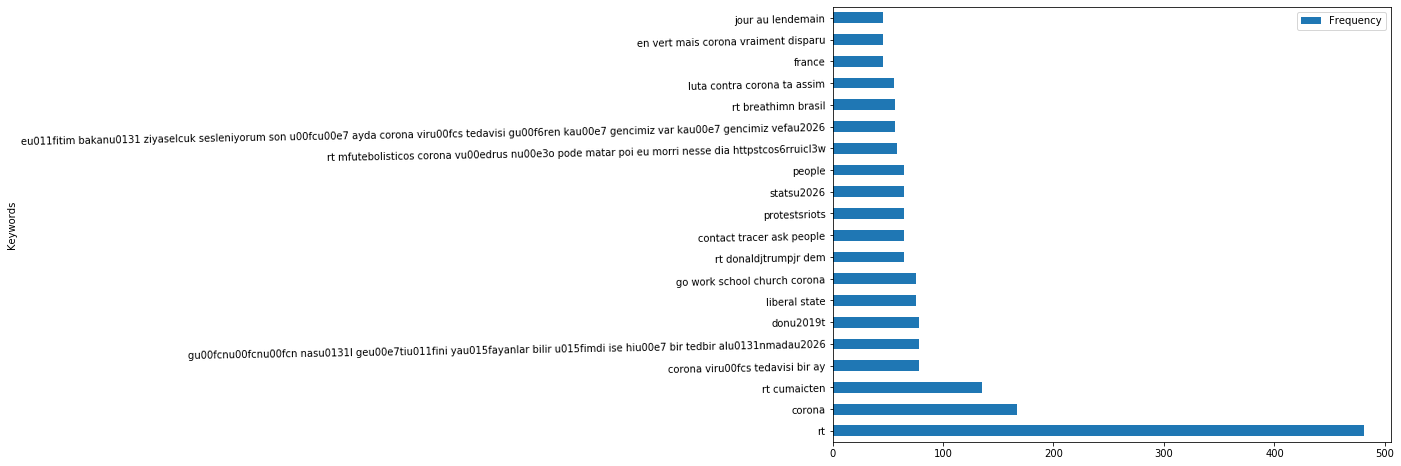

In [42]:
df_fDist = freqDistRDD.toDF() #converting RDD to spark dataframe
df_fDist.createOrReplaceTempView("myTable") 
df2 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 20") #renaming columns 
pandD = df2.toPandas() #converting spark dataframes to pandas dataframes
pandD.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))

In [45]:
from wordcloud import WordCloud

In [46]:
###Word cloud is a novelty visual representation of text data, typically used to depict keyword metadata (tags) on websites or to visualize free form text. Tags are usually single words, and the importance of each tag is shown with font size or color.

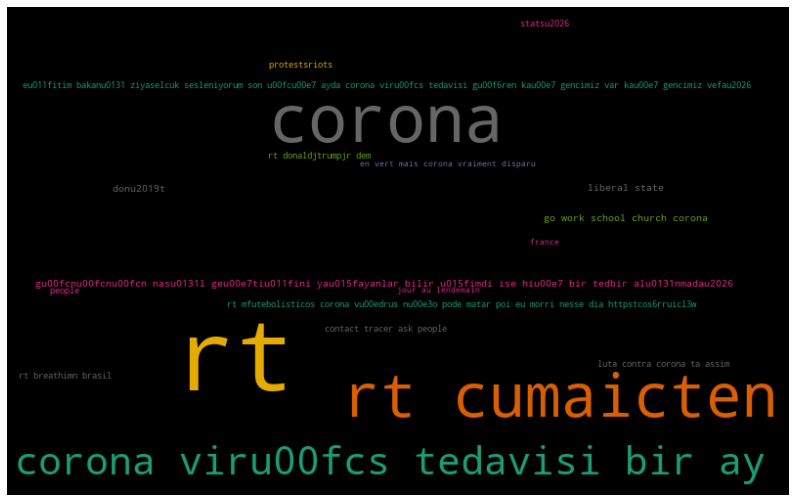

In [47]:
wordcloudConvertDF = pandD.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDF))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()